In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
from glob import glob
from tqdm.notebook import tqdm
import random
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

In [15]:
def rectify_img(inp, warp):
    # before using sift, convert the image to uint8 grayscale
    # warped_img_uint8 = (warp*255).astype(np.uint8)
    # input_img_uint8 = (inp*255).astype(np.uint8)
    input_gray = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
    warped_gray = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
    
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints and compute descriptors
    keypoints_input, descriptors_input = sift.detectAndCompute(input_gray, None)
    keypoints_warped, descriptors_warped = sift.detectAndCompute(warped_gray, None)
    
    # matcher = cv2.BFMatcher()
    # match_pairs = matcher.knnMatch(descriptors_input, descriptors_warped, k=2)
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    match_pairs = matcher.match(descriptors_input, descriptors_warped)

    # good_matches = {}
    # for m, n in match_pairs:
    #     if m.distance < 0.75 < n.distance:
    #         good_matches.append(m)
    
    src_pts = np.float32([keypoints_input[m.queryIdx].pt for m in match_pairs]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints_warped[m.trainIdx].pt for m in match_pairs]).reshape(-1, 1, 2)
    
    homography, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC)
    
    restored_img = cv2.warpPerspective(warp, homography, (inp.shape[1], inp.shape[0]))
    
    return restored_img
    

In [16]:
import largestinteriorrectangle as lir
import numpy as np

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def psnr_ssim_rect(orig_img, rectified_img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(rectified_img, cv2.COLOR_BGR2GRAY)
    # Threshold the image to create a binary image (black and white)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    grid = thresh.astype(np.bool)

    rectangle = lir.lir(grid)
    
    (x_min, y_min) = lir.pt1(rectangle)
    (x_max, y_max) = lir.pt2(rectangle)

    # Crop the image using the inscribed rectangle's coordinates
    cropped_img = orig_img[y_min:y_max, x_min:x_max]
    cropped_img_rect = rectified_img[y_min:y_max, x_min:x_max]

    
    psnr_out = psnr(cropped_img, cropped_img_rect)
    ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)

    return (psnr_out, ssim_out)

In [4]:
# gt_files = natsorted(glob("D:\\file_yyux\\UCLA\\23S-courses\\188\\FP\\stage2_project_data\\stage2_rectification\\input_imgs\\*"))
gt_files = natsorted(glob("input_imgs/*"))
wp_files = natsorted(glob("warped_imgs/*"))

print(len(gt_files))
print(len(wp_files))

11
11


0it [00:00, ?it/s]

The warped image:


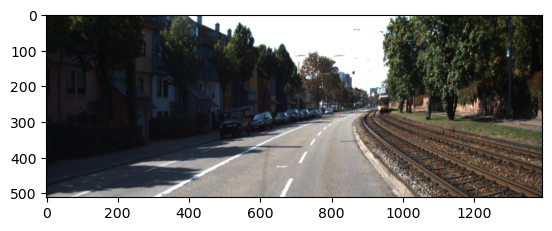

The ground truth image:


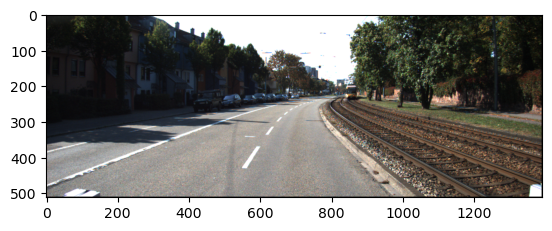

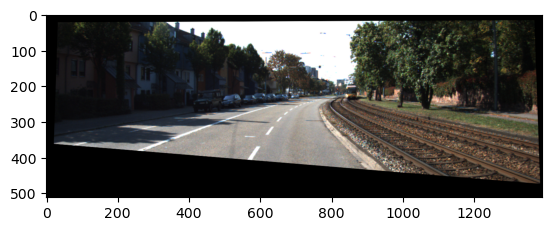

C:\Users\yyxyy\AppData\Local\Temp\ipykernel_15624\488220496.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grid = thresh.astype(np.bool)
C:\Users\yyxyy\AppData\Local\Temp\ipykernel_15624\488220496.py:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_out = ssim(cropped_img, cropped_img_rect, multichannel=True)


The warped image:


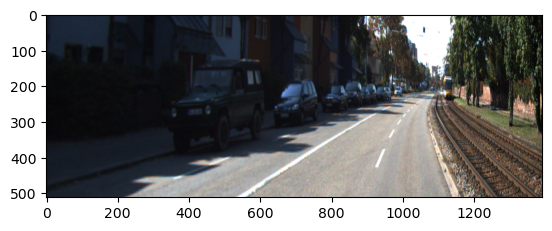

The ground truth image:


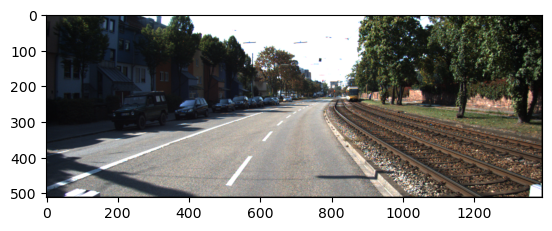

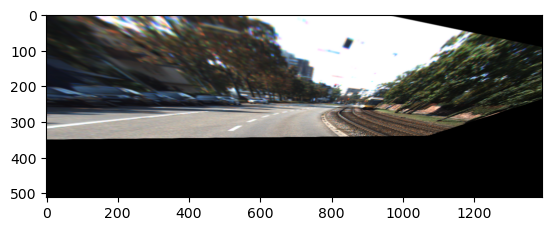

The warped image:


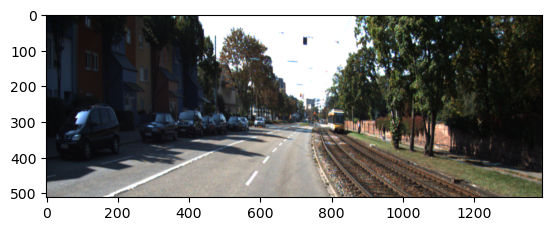

The ground truth image:


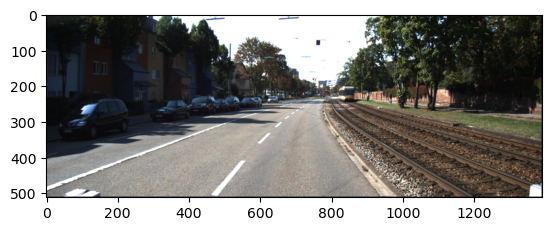

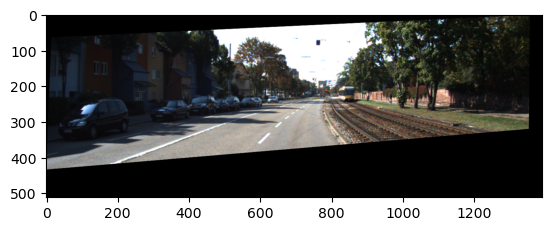

The warped image:


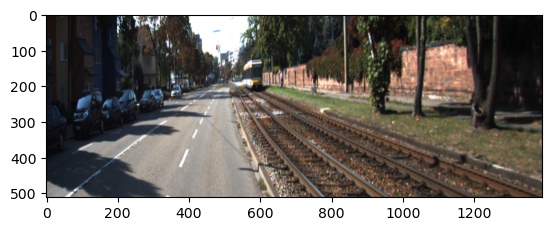

The ground truth image:


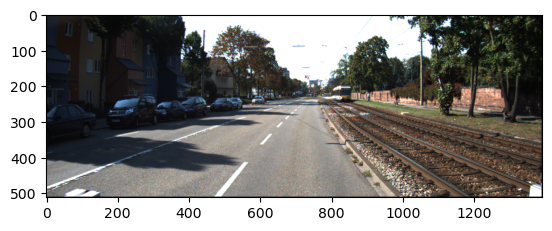

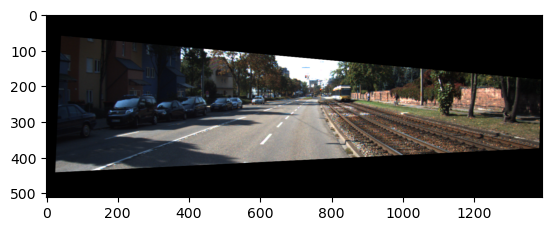

The warped image:


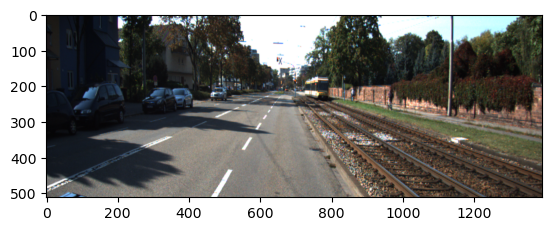

The ground truth image:


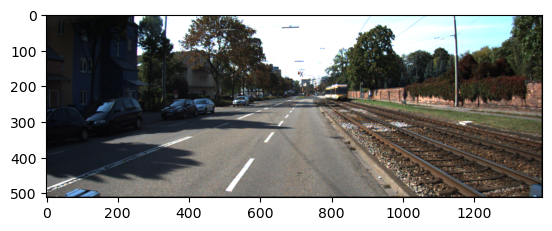

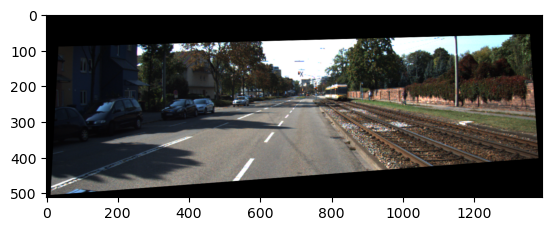

The warped image:


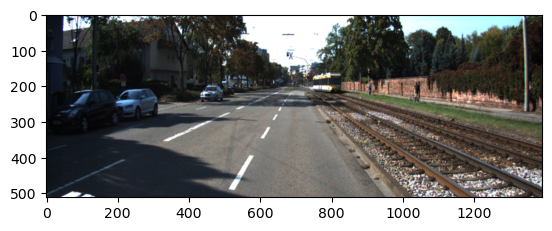

The ground truth image:


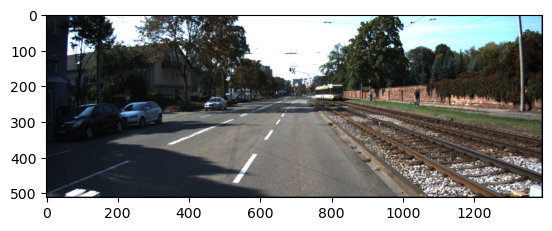

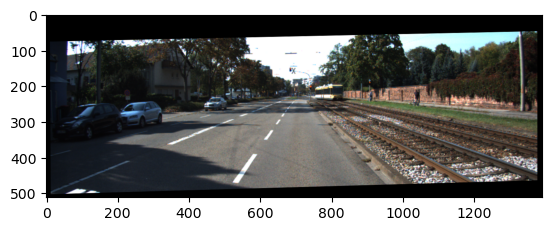

The warped image:


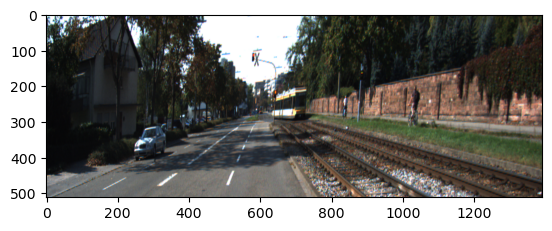

The ground truth image:


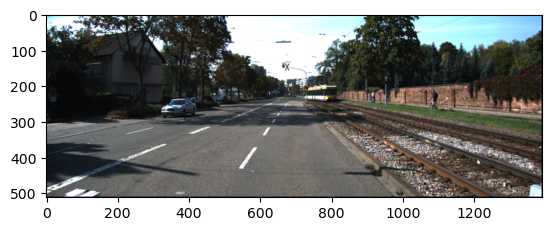

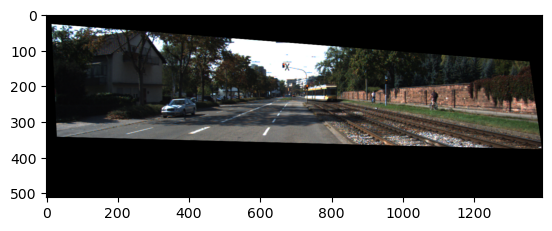

The warped image:


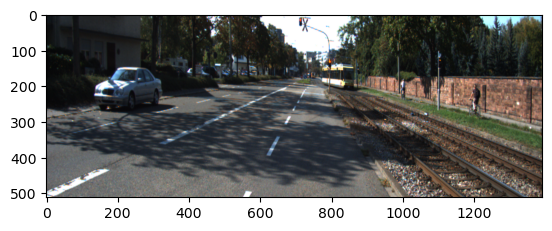

The ground truth image:


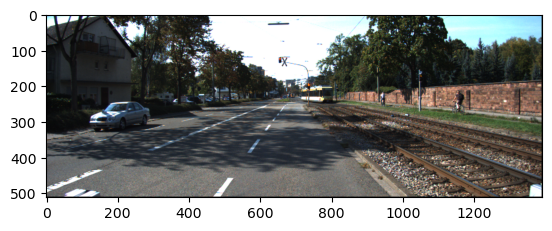

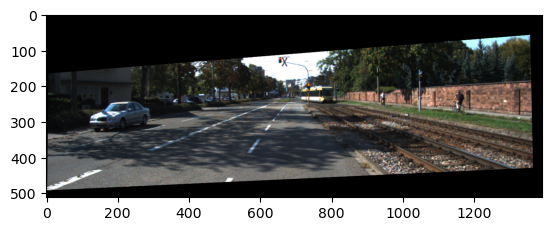

The warped image:


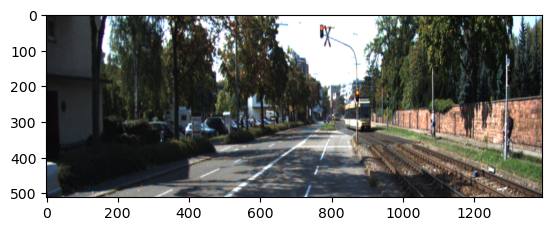

The ground truth image:


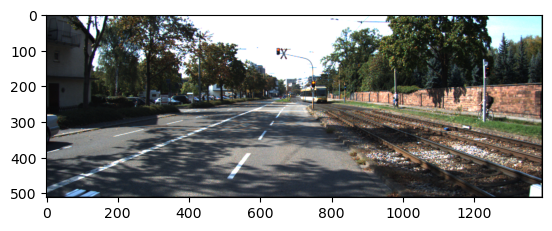

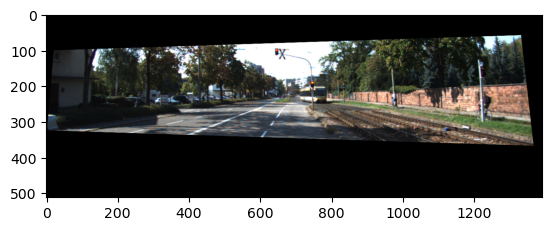

The warped image:


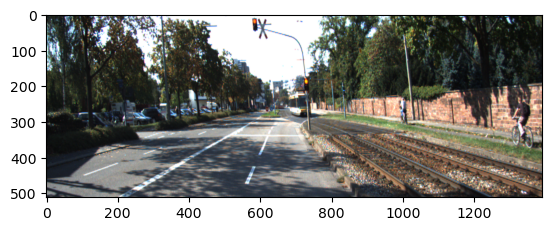

The ground truth image:


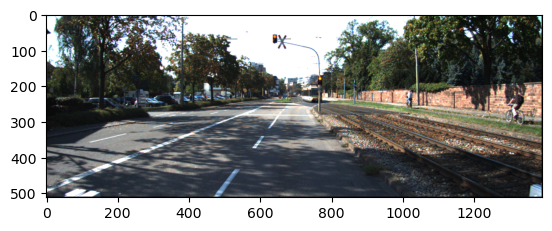

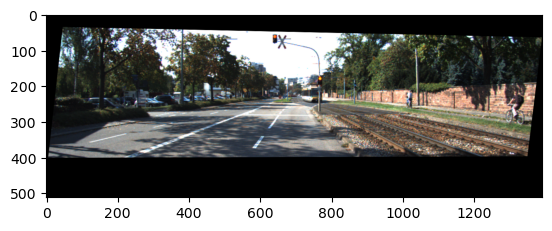

The warped image:


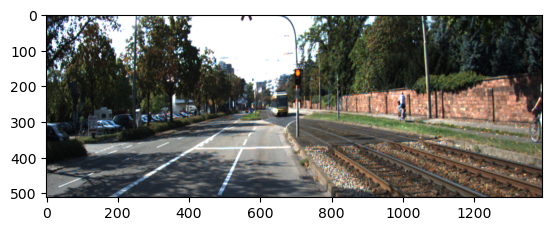

The ground truth image:


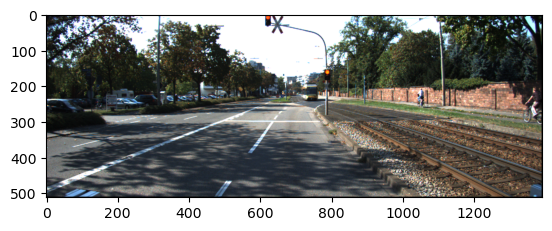

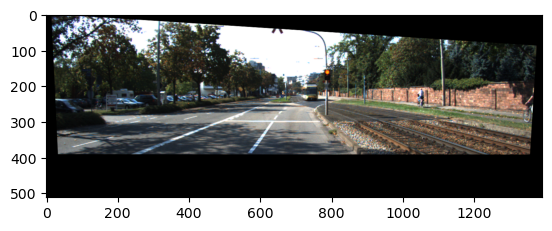

average psnr = 29.804295971703194
average ssim = 0.8797458656990248


In [17]:
# The benchmark for this section will be an average of between all 11 images.
# PSNR = 30.0
# SSIM = 0.90  

# initialization
psnr_sum = 0
ssim_sum = 0

for wp_file, gt_file in tqdm(zip(wp_files, gt_files)):
    wp_img = np.array(Image.open(wp_file))
    gt_img = np.array(Image.open(gt_file))
    print("The warped image:")
    plt.imshow(wp_img)
    plt.show()
    print("The ground truth image:")
    plt.imshow(gt_img)
    plt.show()

    wp_img = np.uint8(wp_img)
    gt_img = np.uint8(gt_img)
    restored_img = rectify_img(gt_img, wp_img)
    plt.imshow(restored_img)
    plt.show()
    psnr_out, ssim_out = psnr_ssim_rect(gt_img, restored_img)
    psnr_sum += psnr_out
    ssim_sum += ssim_out

psnr = psnr_sum / len(gt_files)
ssim = ssim_sum / len(gt_files)
print("average psnr =", psnr)
print("average ssim =", ssim)

## stereo

In [9]:
def stereo_img(left,right, gt):
    rmse_best = 10000
    disparity_best = np.zeros_like(gt)
    for d in range(10):
        for b in range(50):
            stereo = cv.StereoBM_create(numDisparities=d*16, blockSize=b*2+5)
            disparity_map = stereo.compute(left, right)
            disparity_map = cv.normalize(disparity_map, None, alpha = 0, beta=d*16, norm_type=cv.NORM_MINMAX,dtype=cv.CV_32F)
            mask = np.logical_or(disparity_map == 0, gt == 0)
            mask_err = np.ma.array(np.square(disparity_map - gt), mask=mask)
            rmse = np.sqrt(mask_err.mean())
            if rmse < rmse_best:
                rmse_best = rmse
                disparity_best = disparity_map
    return disparity_best, rmse_best
